In [1]:
import inspect
import L96_model
import imp
imp.reload(L96_model)
import matplotlib.pyplot as plt
import numpy as np

[Lorenz (1996)](https://www.ecmwf.int/en/elibrary/10829-predictability-problem-partly-solved) describes a "two time-scale" model in two equations (2 and 3) which are:
\begin{align}
\frac{d}{dt} X_k
&= - X_{k-1} \left( X_{k-2} - X_{k+1} \right) - X_k + F - \left( \frac{hc}{b} \right) \sum_{j=0}^{J-1} Y_{j,k}
\\
\frac{d}{dt} Y_{j,k}
&= - cbY_{j+1,k} \left( Y_{j+2,k} - X_{j-1,k} \right) - c Y_{j,k} + F - \left( \frac{hc}{b} \right) \sum_{j=0}^{J-1} Y_{j,k}
\end{align}
Here, we added a term $F$ in the first equation for generality, following [Wilks (2005)](http://rmets.onlinelibrary.wiley.com/doi/abs/10.1256/qj.04.03).
$X_k$ are the "large scale" with $K$ degrees of freedom ($k=0,1,2,\ldots,K-1$, using python indexing starting at $k=0$). The $k$ index is periodic so that, for example, $k=K$ is referring to $k=0$ and $k=-1$ is referring to $k=K-1$. The $j$ indices represent a sub-division of each $k$-element, so that $J$ Y-values are coupled to a single $X$ value. When $j+1,k$ refers to a values beyond $J$, it is cycled to refer to the first value of with $1,k+1$. The overall structure is illustrated in Fig. 1.


<img src="https://www.researchgate.net/publication/319201436/figure/fig1/AS:869115023589376@1584224577926/Visualisation-of-a-two-scale-Lorenz-96-system-with-J-8-and-K-6-Global-scale-values.png" width=400> *Fig. 1: Visualisation of a two-scale Lorenz '96 system with J = 8 and K = 6. Global-scale values (X k ) are updated based on neighbouring values and a reduction applied to the local-scale values (Y j,k ) associated with that value. Local-scale values are updated based on neighbouring values and the associated global-scale value. The neighbourhood topology of both the local and global-scale values is circular. Image from [Exploiting the chaotic behaviour of atmospheric models with reconfigurable architectures - Scientific Figure on ResearchGate.](https://www.researchgate.net/figure/Visualisation-of-a-two-scale-Lorenz-96-system-with-J-8-and-K-6-Global-scale-values_fig1_319201436)*



In [2]:
from L96_model import L96_eq2_xdot, L96_eq3_ydot
print( inspect.getsource(L96_eq2_xdot) )
print( inspect.getsource(L96_eq3_ydot) )

def L96_eq2_xdot(X, t, Y, F, h, b, c):
    """
    Calculate the time rate of change for the X variables for the Lorenz '96, equation 2:
        d/dt X[k] = -X[k-1] ( X[k-2] - X[k+1] ) - X[k] + F - h.c/b sum_j Y[j,k]

    Args:
        X : Values of X variables at the current time step
        t : Time
        Y : Values of Y variables at the current time step
        F : Forcing term
        h : coupling coefficient
        b : ratio of amplitudes
        c : time-scale ratio
    Returns:
        dXdt : Array of X time tendencies
    """

    JK,K = len(Y),len(X)
    J = JK//K
    assert JK==J*K, "X and Y have incompatible shapes"
    Xdot = np.zeros(K)
    hcb = (h*c)/b

    Ysummed = Y.reshape((K,J)).sum(axis=-1)
    
    for k in range(K):
        Xdot[k] = ( X[(k+1)%K] - X[k-2] ) * X[k-1] - X[k] + F + hcb * Ysummed[k]
    return Xdot

def L96_eq3_ydot(Y, t, X, h, b, c):
    """
    Calculate the time rate of change for the X variables for the Lorenz '96, equation 2:
      d/dt X[k

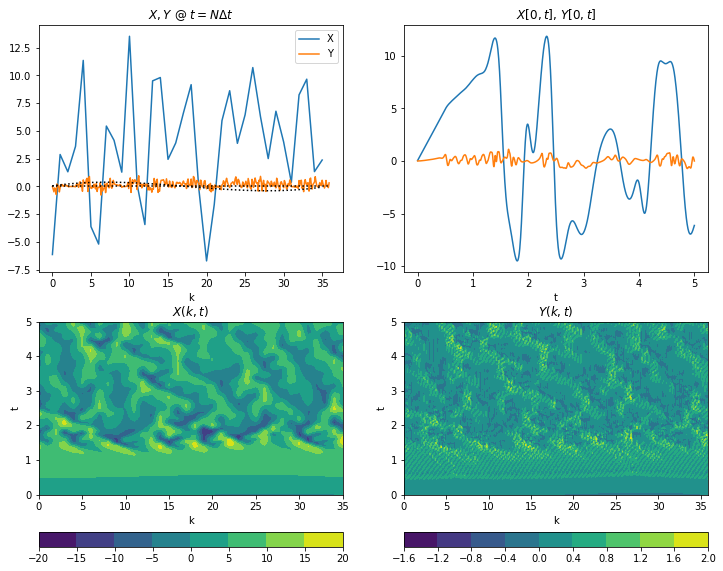

In [3]:
from L96_model import integrator_2d, RK4_XY, RK2_XY, EulerFwd_XY

J = 10 # Number of Y degrees of freedom per single X variable
K = 36 # Number of degree of freedom in X variable
nt = 1000 # Number of time steps
dt = 0.005 # time step
F = 10. # Focring
h = 1.0 # Coupling coefficient
b = 10.0 # ratio of amplitudes
c = 10.0 # time-scale ratio

# Initial conditions
k = np.arange(K) # For coordinate in plots
sk = 2 * ( 0.5 + k ) / K - 1 # A symmetric coordinate from -1..+1
Xinit = sk*(sk-1)*(sk+1) # Initial conditions
j = np.arange(J*K) # For coordinate in plots
sj = 2 * ( 0.5 + j ) / (J*K) - 1 # A symmetric coordinate from -1..+1
Yinit = 0*sj*(sj-1)*(sj+1)

# "Run" model
X,Y,t = integrator_2d(L96_eq2_xdot, L96_eq3_ydot, RK4_XY, dt, Xinit, Yinit, nt, F, h, b, c)

plt.figure(figsize=(12,10))
plt.subplot(221); # Snapshot of X[k]
plt.plot(k, X[-1], label='X');
plt.plot(j/J, Y[-1], label='Y')
plt.legend(); plt.xlabel('k'); plt.title('$X,Y$ @ $t=N\Delta t$');
plt.plot(k, Xinit, 'k:')
plt.plot(j/J, Yinit, 'k:')
plt.subplot(222); # Sample time-series X[0](t), Y[0](t)
plt.plot(t, X[:,0], label='X');
plt.plot(t, Y[:,0], label='Y');
plt.xlabel('t'); plt.title('$X[0,t]$, $Y[0,t]$');
plt.subplot(223); # Full model history of X
plt.contourf(k,t,X); plt.colorbar(orientation='horizontal'); plt.xlabel('k'); plt.ylabel('t'); plt.title('$X(k,t)$');
plt.subplot(224); # Full model history of Y
plt.contourf(j/J,t,Y); plt.colorbar(orientation='horizontal'); plt.xlabel('k'); plt.ylabel('t'); plt.title('$Y(k,t)$');